In [1]:
import os
from fastai.vision.all import *
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from fastai.callback.hook import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
!git clone https://github.com/KevivJaknap/BreastCancerPrediction.git

Cloning into 'BreastCancerPrediction'...
remote: Enumerating objects: 1601, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 1601 (delta 8), reused 5 (delta 1), pack-reused 1583
Receiving objects: 100% (1601/1601), 44.25 MiB | 22.52 MiB/s, done.
Resolving deltas: 100% (61/61), done.


In [3]:
def get_labels(file_path):
    if file_path[0] == 'N':
        return 'healthy'
    else:
        return 'unhealthy'
test_path = '/content/BreastCancerPrediction/dataset_test/'
train_path = '/content/BreastCancerPrediction/dataset_train/'

In [4]:
def split_files(beta, base_path=train_path):
    healthy_files = []
    unhealthy_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.startswith('N'):
                healthy_files.append((base_path+file, 'healthy'))
            else:
                unhealthy_files.append((base_path+file, 'unhealthy'))
    len_healthy = len(healthy_files)
    len_unhealthy = len(unhealthy_files)


    #split into two sets
    first = healthy_files[:] + random.sample(unhealthy_files, int(len_unhealthy*beta))
    second = random.sample(healthy_files, int(len_healthy*beta)) + unhealthy_files[:]
    random.shuffle(first)
    random.shuffle(second)

    print(f"First contains {len_healthy} healthy and {len(first) - len_healthy} unhealthy")
    print(f"Second contains {len(second)-len_unhealthy} healthy and {len_unhealthy} unhealthy")
    return first, second

In [5]:
class CNN:
    def __init__(self, id, files):
        self.id = id
        self.files = files
        self.dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=ColReader(0),
                   get_y=ColReader(1),
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
        self.dls = self.dblock.dataloaders(self.files, bs=64)
        self.learn = vision_learner(self.dls, resnet34, metrics=accuracy)

    def train(self, epochs):
        self.learn.fine_tune(epochs)

    def show_batch(self):
        self.dls.show_batch()

    def save(self):
        self.learn.export(f'./models/model_{self.id}.pkl')

    def load(self):
        self.learn = load_learner(f'./models/model_{self.id}.pkl')

    def predict(self, file_path):
        img = Image.open(file_path)
        return self.learn.predict(img)

    def plot(self):
        self.learn.recorder.plot_loss()

    def show_results(self):
        self.learn.show_results()

In [47]:
files1, files2 = split_files(0.75)
files0 = split_files(1)[0]
model0 = CNN(id = 0, files = files0)
model1 = CNN(id = 1, files = files0)
model2 = CNN(id = 2, files = files0)
model3 = CNN(id = 3, files = files0)
model0.train(10)
model1.train(10)
model2.train(10)

First contains 642 healthy and 480 unhealthy
Second contains 481 healthy and 640 unhealthy
First contains 642 healthy and 640 unhealthy
Second contains 642 healthy and 640 unhealthy


epoch,train_loss,valid_loss,accuracy,time
0,0.778373,0.895789,0.714844,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.407618,0.457386,0.812500,00:13
1,0.304735,0.104709,0.953125,00:11
2,0.227336,0.119033,0.957031,00:11
3,0.198546,0.064665,0.976562,00:11
4,0.196439,0.584859,0.847656,00:11
5,0.171428,0.381691,0.906250,00:11
6,0.137195,0.232672,0.914062,00:11
7,0.107566,0.146706,0.941406,00:11
8,0.087617,0.157697,0.941406,00:11
9,0.072333,0.184735,0.933594,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.794675,0.345546,0.855469,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.343726,0.497003,0.808594,00:11
1,0.294308,0.147315,0.941406,00:10
2,0.263924,0.052632,0.972656,00:11
3,0.212227,0.421330,0.847656,00:11
4,0.166947,0.381839,0.914062,00:11
5,0.140746,0.105010,0.949219,00:11
6,0.134308,0.195139,0.925781,00:11
7,0.103446,0.227704,0.925781,00:11
8,0.078232,0.212285,0.925781,00:11
9,0.063303,0.153417,0.933594,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.856104,0.528964,0.835938,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.356820,0.251656,0.921875,00:10
1,0.312402,0.128878,0.957031,00:11
2,0.229835,0.099541,0.972656,00:11
3,0.199775,0.434428,0.902344,00:11
4,0.163041,0.301933,0.929688,00:11
5,0.133082,0.228617,0.914062,00:11
6,0.113391,0.205514,0.929688,00:11
7,0.096428,0.062439,0.980469,00:11
8,0.083110,0.065332,0.964844,00:11
9,0.064305,0.071279,0.968750,00:12


In [39]:
def get_metrics(y_actual, y_preds):
# Compute the metrics
  model_accuracy = accuracy_score(y_actual, y_preds)
  f1 = f1_score(y_actual, y_preds, average='weighted')
  precision = precision_score(y_actual, y_preds, average='weighted')
  recall = recall_score(y_actual, y_preds, average='weighted')

  return {'accuracy': model_accuracy, 'f1': f1, 'precision': precision, 'recall': recall}

def get_test_accuracy(model):
  test_path = '/content/BreastCancerPrediction/dataset_test/'
  test_xy = split_files(1, base_path=test_path)[0]
  x, y = [], []
  for a, b in test_xy:
    x.append(a)
    y.append(b)
  test_dl = model.dls.test_dl(x)
  preds = model.learn.get_preds(dl=test_dl)
  preds = preds[0].argmax(dim=1)
  preds = [model.dls.vocab[i] for i in preds]
  return get_metrics(y, preds), len(preds)

def get_test_values(model):
  test_path = '/content/BreastCancerPrediction/dataset_test/'
  test_xy = split_files(1, base_path=test_path)[0]
  x, y = [], []
  for a, b in test_xy:
    x.append(a)
    y.append(b)
  test_dl = model.dls.test_dl(x)
  preds = model.learn.get_preds(dl=test_dl)
  preds = preds[0].argmax(dim=1)
  preds = [model.dls.vocab[i] for i in preds]
  return y, preds

def get_testxy():
  test_path = '/content/BreastCancerPrediction/dataset_test/'
  test_xy = split_files(1, base_path=test_path)[0]
  x, y = [], []
  for a, b in test_xy:
    x.append(a)
    y.append(b)
  return x, y

In [8]:
def plot(y_actual, y_preds):
  # Compute the confusion matrix
  cm = confusion_matrix(y_actual, y_preds)

  # Plot the confusion matrix
  plt.figure(figsize=(10,10))
  sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', xticklabels=['healthy', 'unhealthy'], yticklabels=['healthy', 'unhealthy']);
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  plt.title('Confusion Matrix', size = 15);
  plt.show()

In [49]:
print(get_test_accuracy(model0))
print(get_test_accuracy(model1))
print(get_test_accuracy(model2))
print(get_test_accuracy(model3))

First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


({'accuracy': 0.9416666666666667, 'f1': 0.9414674935544561, 'precision': 0.9477611940298508, 'recall': 0.9416666666666667}, 240)
First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


({'accuracy': 0.9208333333333333, 'f1': 0.9208209616085848, 'precision': 0.9210965186574943, 'recall': 0.9208333333333333}, 240)
First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


({'accuracy': 0.9375, 'f1': 0.9372549019607843, 'precision': 0.9444444444444444, 'recall': 0.9375}, 240)
First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


({'accuracy': 0.5, 'f1': 0.3333333333333333, 'precision': 0.25, 'recall': 0.5}, 240)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


{'accuracy': 0.9208333333333333, 'f1': 0.9205228758169935, 'precision': 0.9275132275132275, 'recall': 0.9208333333333333}


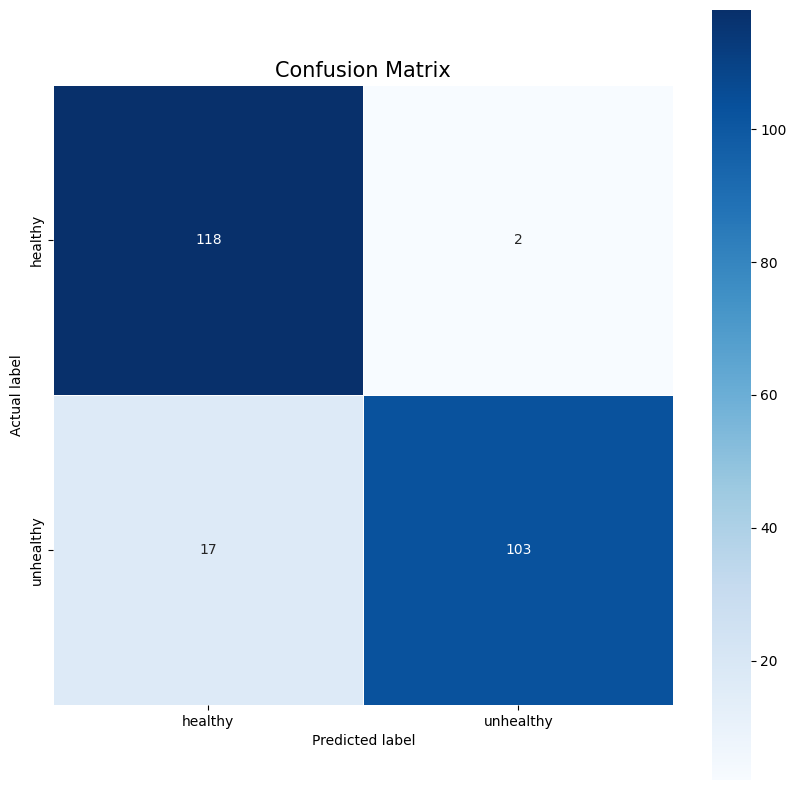

In [10]:
y_actual, y_preds = get_test_values(model0)
print(get_metrics(y_actual, y_preds))
plot(y_actual, y_preds)

In [11]:
def get_class_probs(model, path=test_path):
  test_xy = split_files(1, base_path=path)[0]
  x, y = [], []
  for a, b in test_xy:
    x.append(a)
    y.append(b)
  test_dl = model.dls.test_dl(x)
  preds = model.learn.get_preds(dl=test_dl)
  print(f"Length of data is {len(preds[0])}")
  return preds, y

In [ ]:
# preds, y = get_class_probs(model0, path=train_path)

First contains 642 healthy and 640 unhealthy
Second contains 642 healthy and 640 unhealthy


Length of data is 1282


In [ ]:
preds2, y = get_class_probs(model1, path=train_path)

First contains 642 healthy and 640 unhealthy
Second contains 642 healthy and 640 unhealthy


Length of data is 1282


In [ ]:
print(preds[0][0], preds2[0][0])

tensor([5.6217e-06, 9.9999e-01]) tensor([9.9906e-01, 9.3979e-04])


In [ ]:
train_preds, train_preds2 = preds[0], preds2[0]
train_x = torch.cat((preds, preds2), dim=1)
train_y = y
print(len(train_x), len(train_y))

1282 1282


In [ ]:
preds, y = get_class_probs(model0, path=test_path)
preds2, y = get_class_probs(model1, path=test_path)
preds, preds2 = preds[0], preds2[0]
test_x = torch.cat((preds, preds2), dim=1)
test_y = y
print(len(test_x), len(test_y))

First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


Length of data is 240
First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy


Length of data is 240
240 240


In [ ]:
labels = {'healthy': 0, 'unhealthy': 1}
train_y = [labels[i] for i in train_y]
test_y = [labels[i] for i in test_y]

In [12]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Define optimizer and loss function
        self.optimizer = optim.SGD(self.parameters(), lr=0.01)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def train_model(self, train_data, train_labels, epochs=10, batch_size=32):
        for epoch in range(epochs):
            running_loss = 0.0
            for i in range(0, len(train_data), batch_size):
                inputs = train_data[i:i+batch_size]
                labels = train_labels[i:i+batch_size]

                self.optimizer.zero_grad()  # Zero the gradients
                outputs = self(inputs)      # Forward pass
                loss = self.criterion(outputs, labels)  # Compute the loss
                loss.backward()             # Backward pass
                self.optimizer.step()       # Optimize the weights
                running_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {running_loss / (len(train_data) / batch_size)}")

    def test_model(self, test_data, test_labels, batch_size=32):
        correct = 0
        total = 0
        with torch.no_grad():
            for i in range(0, len(test_data), batch_size):
                inputs = test_data[i:i+batch_size]
                labels = test_labels[i:i+batch_size]

                outputs = self(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")


In [25]:
class Ensemble:
  def __init__(self, models, train_path=train_path, test_path=test_path):
    self.models = models
    self.train_path = train_path
    self.test_path = test_path
    self.ensemble_model = ClassificationModel(input_size=2*len(models), hidden_size=50, output_size=2)
    self._generate_data()
    self._generate_ensemble_data()

  def train_ensemble(self, epochs=10):
    self.ensemble_model.train_model(self.train_ensemble_x, self.train_y, epochs=epochs)

  def get_test_accuracy(self):
    self.ensemble_model.test_model(self.test_ensemble_x, self.test_y)

  def _generate_ensemble_data(self):
    train_ensemble_x = []
    train_ensemble_y = []
    test_ensemble_x = []
    test_ensemble_y = []
    for model in self.models:
        print(f"Generating train data for model {model.id}")
        pred_values = self._generate_single_model_data(model, train=True)
        train_ensemble_x.append(pred_values[0])
        print(f"Generating test data for model {model.id}")
        pred_values = self._generate_single_model_data(model, train=False)
        test_ensemble_x.append(pred_values[0])
    # train_ensemble_x = torch.tensor(train_ensemble_x)
    self.train_ensemble_x = torch.cat(train_ensemble_x, dim=1)
    self.train_ensemble_y = torch.tensor(self.train_y)
    # test_ensemble_x = torch.tensor(test_ensemble_x)
    self.test_ensemble_x = torch.cat(test_ensemble_x, dim=1)
    self.test_ensemble_y = torch.tensor(self.test_y)

    return None

  def _generate_data(self):
    labels = {'healthy': 0, 'unhealthy': 1}
    self.train_files = split_files(1, train_path)[0]
    self.test_files = split_files(1, test_path)[0]
    self.len_train = len(self.train_files)
    self.len_test = len(self.test_files)
    print(f"Length of train files is {self.len_train}")
    print(f"Length of test files is {self.len_test}")
    self.train_x = []
    self.train_y = []

    #generating and storing train X and train Y values
    for x, y in self.train_files:
      self.train_x.append(x)
      self.train_y.append(labels[y])

    self.test_x = []
    self.test_y = []

    #generating and storing test X and test Y values
    for x, y in self.test_files:
      self.test_x.append(x)
      self.test_y.append(labels[y])

    return None

  def _generate_single_model_data(self, model, train=True):
    if train:
      data_x = self.train_x
    else:
      data_x = self.test_x

    test_dl = model.dls.test_dl(data_x)
    preds = model.learn.get_preds(dl=test_dl)
    print(f"Length of data is {len(preds[0])}")

    #return probabilities of the classes
    return preds

In [ ]:
def train_ensemble(models, train_path=train_path, test_path=test_path, epochs=10):
    def generate_data(train_path, test_path):
        labels = {'healthy': 0, 'unhealthy': 1}
        train_files = split_files(1, train_path)[0]
        test_files = split_files(1, test_path)[0]
        train_x, train_y = [], []
        for x, y in train_files:
            train_x.append(x)
            train_y.append(labels[y])
        test_x, test_y = [], []
        for x, y in test_files:
            test_x.append(x)
            test_y.append(labels[y])
        return train_x, train_y, test_x, test_y

    def generate_single_model_data(model, data_x):
        test_dl = model.dls.test_dl(data_x)
        preds = model.learn.get_preds(dl=test_dl)
        return preds

    train_x, train_y, test_x, test_y = generate_data(train_path, test_path)

    train_ensemble_x = []
    test_ensemble_x = []


    ensemble_model = ClassificationModel(input_size=2*len(models), hidden_size=50, output_size=2)
    ensemble_model.train_model(train_ensemble_x, train_y, epochs=epochs)
    ensemble_model.test_model(test_ensemble_x, test_y)

In [50]:
models = (model0, model1, model2)
def generate_data(train_path, test_path):
  labels = {'healthy': 0, 'unhealthy': 1}
  train_files = split_files(1, train_path)[0]
  test_files = split_files(1, test_path)[0]
  train_x, train_y = [], []
  for x, y in train_files:
      train_x.append(x)
      train_y.append(labels[y])
  test_x, test_y = [], []
  for x, y in test_files:
      test_x.append(x)
      test_y.append(labels[y])
  return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = generate_data(train_path, test_path)

def generate_single_model_data(model, data_x):
  test_dl = model.dls.test_dl(data_x)
  preds = model.learn.get_preds(dl=test_dl)
  return preds

train_ensemble_x = []
test_ensemble_x = []
for model in models:
  print(f"Generating train data for model {model.id}")
  pred_values = generate_single_model_data(model, train_x)
  train_ensemble_x.append(pred_values[0])
  print(f"Generating test data for model {model.id}")
  pred_values = generate_single_model_data(model, test_x)
  test_ensemble_x.append(pred_values[0])

train_ensemble_x = torch.cat(train_ensemble_x, dim=1)
test_ensemble_x = torch.cat(test_ensemble_x, dim=1)

First contains 642 healthy and 640 unhealthy
Second contains 642 healthy and 640 unhealthy
First contains 120 healthy and 120 unhealthy
Second contains 120 healthy and 120 unhealthy
Generating train data for model 0


Generating test data for model 0


Generating train data for model 1


Generating test data for model 1


Generating train data for model 2


Generating test data for model 2


In [51]:
train_y, test_y = torch.tensor(train_y), torch.tensor(test_y)
print(train_y)
print(len(train_y))

tensor([1, 1, 0,  ..., 1, 1, 1])
1282


In [52]:
ensemble_model = ClassificationModel(input_size=2*len(models), hidden_size=50, output_size=2)
ensemble_model.train_model(train_ensemble_x, train_y, epochs=10)
ensemble_model.test_model(test_ensemble_x, test_y)

Epoch 1, Loss: 0.5597156987361342
Epoch 2, Loss: 0.3880470665680265
Epoch 3, Loss: 0.27960388745978915
Epoch 4, Loss: 0.210401499327185
Epoch 5, Loss: 0.16584712164636337
Epoch 6, Loss: 0.13635208937753568
Epoch 7, Loss: 0.1158634359118719
Epoch 8, Loss: 0.1012202273478932
Epoch 9, Loss: 0.09033526254704516
Epoch 10, Loss: 0.0819490775582199
Accuracy on the test set: 95.83%
